### Import data

In [1]:
import pandas as pd

dataset = pd.read_csv('/Users/Hsuweic/Desktop/AI4health/dataset/training dataset.csv')
# dataset = pd.read_csv('/Users/Hsuweic/Desktop/AI4health/dataset/dataset_categories.csv')
print("Training Set:"% dataset.columns, dataset.shape, len(dataset))
print(dataset.columns)
# test = pd.read_csv('/Users/Hsuweic/Desktop/AI4healthcare/hate speech dataset/test.csv')
# print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (5679, 4) 5679
Index(['number', 'tweet', 'label', 'categories'], dtype='object')


In [2]:
hate_speech = dataset['label'].sum()
print("Hate speech: ", hate_speech)
print("Non hate speech: ", len(dataset)-hate_speech)


Hate speech:  1516
Non hate speech:  4163


### Data cleaning

In [3]:
import re

def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(elem)))  
    return df

data_clean = clean_text(dataset, 'tweet')
# print(data_clean.head(10))

### Handle imbalanced data

In [4]:
from sklearn.utils import resample

train_majority = data_clean[data_clean.label == 0]
train_minority = data_clean[data_clean.label == 1]

train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)

train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

label
1    4163
0    4163
Name: count, dtype: int64

### Create pipelines for three models (LogisticRegression / SVC / RandomForest)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


pipeline_logreg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression())
])

pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(kernel='linear'))
])

pipeline_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier())
])

### K-fold cross validation

Cross-validated Accuracy: 0.943 (+/- 0.01)


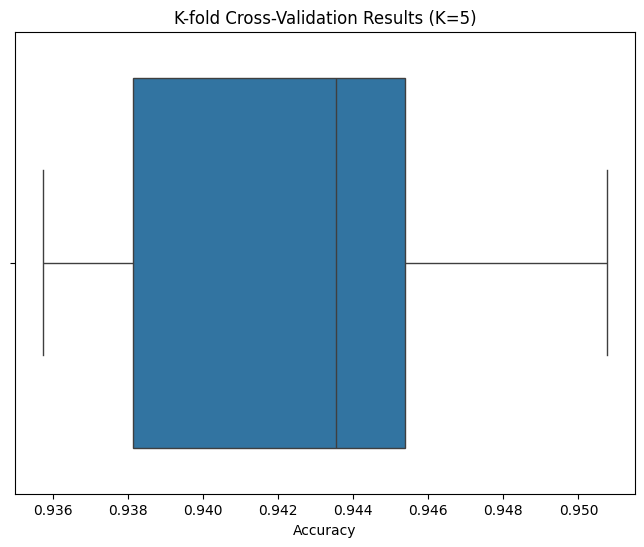

Cross-validated Accuracy: 0.958 (+/- 0.01)


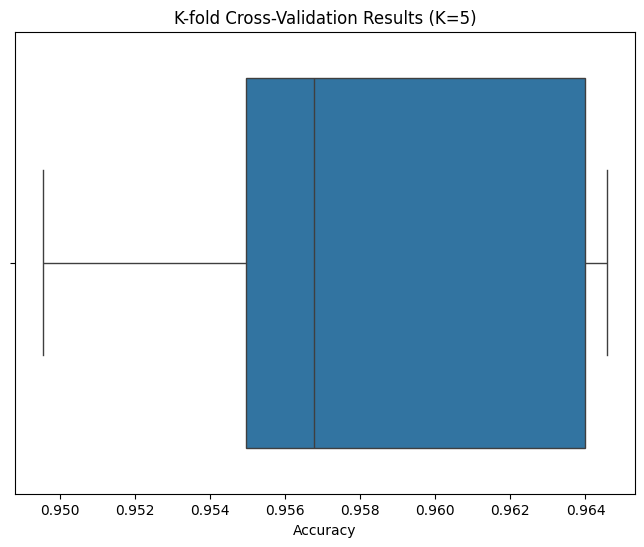

Cross-validated Accuracy: 0.971 (+/- 0.01)


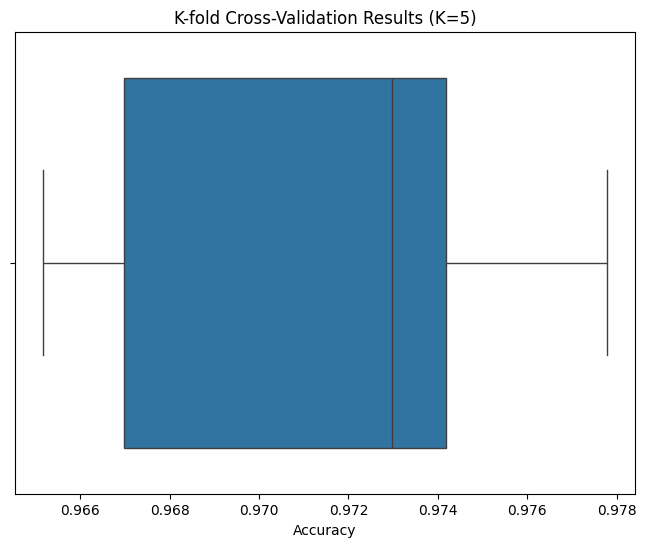

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

pipelines = [pipeline_logreg, pipeline_svm, pipeline_rf]

# Train and evaluate each model
for pipeline in pipelines:
    model_name = pipeline.named_steps[pipeline.steps[-1][0]].__class__.__name__

    # Extract features and labels
    X = train_upsampled['tweet']
    y = train_upsampled['label']
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cross_val_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
    print("Cross-validated Accuracy: %0.3f (+/- %0.2f)" % (cross_val_results.mean(), cross_val_results.std() * 2))

    # Plot the results
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=cross_val_results)
    plt.title('K-fold Cross-Validation Results (K=5)')
    plt.xlabel('Accuracy')
    plt.show()

### Model training

In [8]:
from sklearn.model_selection import train_test_split
#the default test_size is 25%
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['tweet'],
                                                    train_upsampled['label'], test_size=0.2, random_state = 0)
print(X_train.size)
print(y_train.size)
print(X_test.size)
print(y_test.size)

logreg_model = pipeline_logreg.fit(X_train, y_train)
svc_model = pipeline_svm.fit(X_train, y_train)
rf_model = pipeline_rf.fit(X_train, y_train)


6660
6660
1666
1666


### Model Evaluation

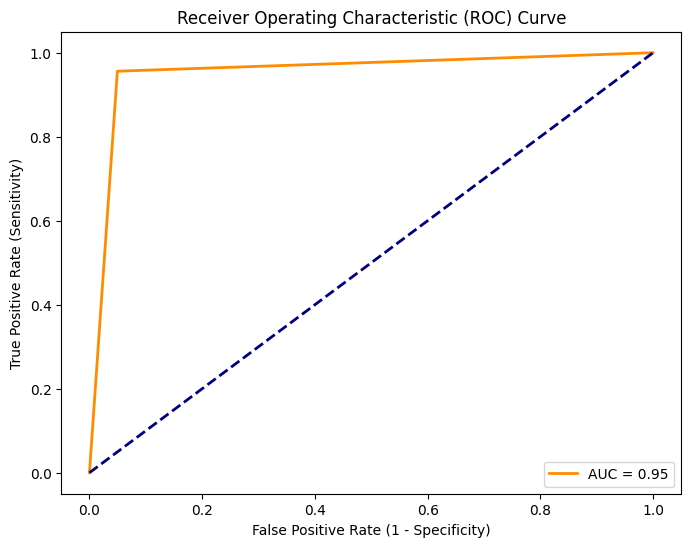

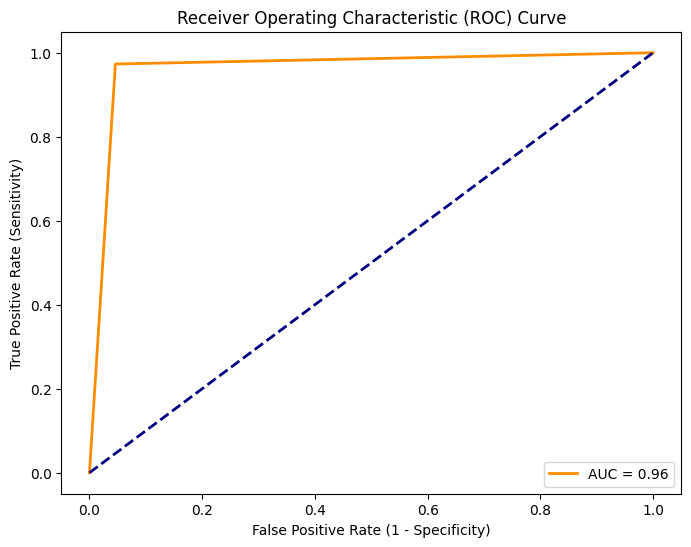

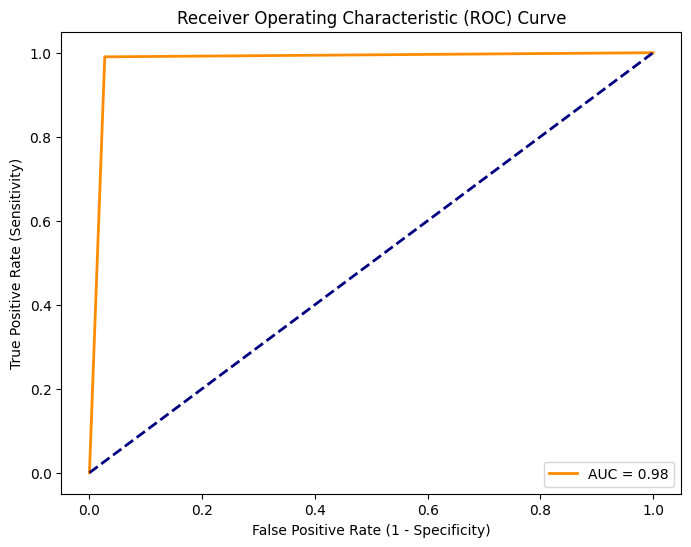

In [9]:
#ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = [logreg_model, svc_model, rf_model]

for model in models:
    y_predict = model.predict(X_test)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


Logistic Regression
                 precision    recall  f1-score   support

Non Hate Speech       0.96      0.95      0.95       848
    Hate Speech       0.95      0.96      0.95       818

       accuracy                           0.95      1666
      macro avg       0.95      0.95      0.95      1666
   weighted avg       0.95      0.95      0.95      1666

Support Vector Classification
                 precision    recall  f1-score   support

Non Hate Speech       0.97      0.95      0.96       848
    Hate Speech       0.95      0.97      0.96       818

       accuracy                           0.96      1666
      macro avg       0.96      0.96      0.96      1666
   weighted avg       0.96      0.96      0.96      1666

Random Forest
                 precision    recall  f1-score   support

Non Hate Speech       0.99      0.97      0.98       848
    Hate Speech       0.97      0.99      0.98       818

       accuracy                           0.98      1666
      macro avg 

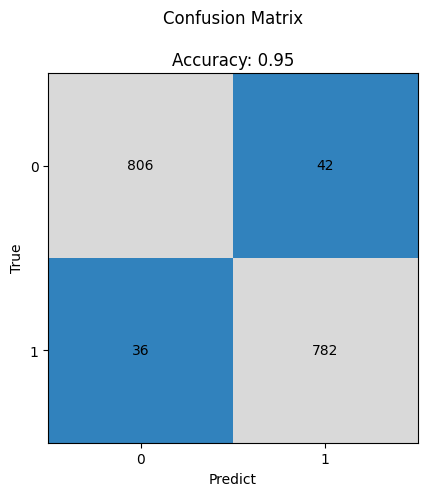

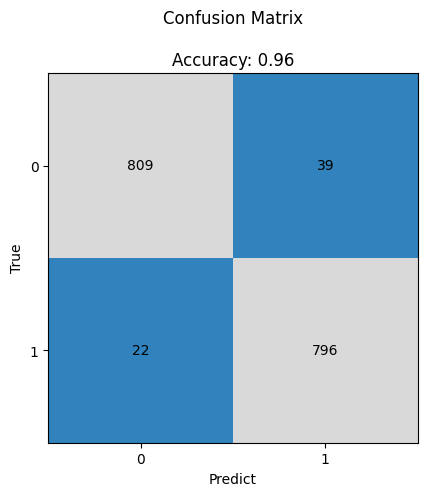

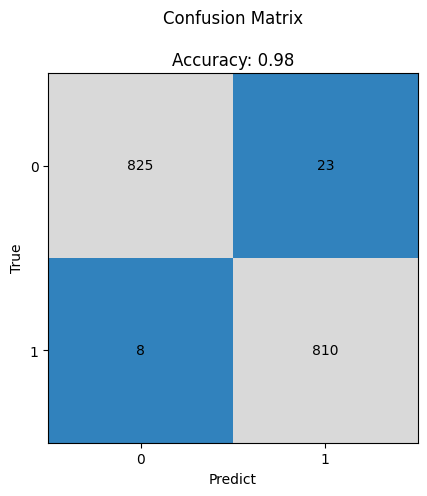

In [19]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

models = [logreg_model, svc_model, rf_model]
class_labels = {0: 'Non Hate Speech', 1: 'Hate Speech'}
model_name = ["Logistic Regression", "Support Vector Classification", "Random Forest"]
idx = 0

for model in models:
    y_predict = model.predict(X_test)

    grid = confusion_matrix(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)

    # Create a confusion matrix plot
    fig, ax = plt.subplots()

    # Plot the confusion matrix
    for (j, i), label in np.ndenumerate(grid):
        ax.text(i, j, label, ha='center', va='center')

    # Display the accuracy in the title
    ax.set_title(f'Confusion Matrix\n\nAccuracy: {accuracy:.2f}')

    # Customize the plot
    ax.imshow(grid, cmap='tab20c')
    ax.set_xticks([1, 0])
    ax.set_yticks([1, 0])
    ax.set_xlabel('Predict')
    ax.set_ylabel('True')

    # Evaluate the model with multinomial (softmax)
    print(model_name[idx])
    idx = idx+1
    print(classification_report(y_test, y_predict, target_names=[class_labels[0], class_labels[1]]))

### Save the model

In [24]:
import joblib

# Save the random forest model due to its highest accuracy
saved_model = rf_model

# Save the model to a file
joblib.dump(saved_model, '/Users/Hsuweic/Desktop/AI4health/model/detection model.joblib')

['/Users/Hsuweic/Desktop/AI4health/model/tfidf_transformer.joblib']